In [1]:
import pandas as pd

# Gensim Tools
import gensim as gs
from gensim.corpora import Dictionary
from gensim.models import TfidfModel, LdaModel

# Tokenization tools
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

# Plotting
import matplotlib.pyplot as plt
import numpy as np

# Clustering
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances


1. Read in the file with project decription data as pandas dataframe
2. Extract the text column
3. Preprocess, and create dictionary
4. Create TFIDF model
5. Experiment with other models
6. Model to dataframe

In [2]:
# The file with all the project data is in "Data/all_data.tsv"
tsvFile = "Data/all_data.tsv"
df = pd.read_csv(tsvFile, sep="\t")

df.head()

Challenge SubChallenge                                            ProjURL  \
0    Health    Equipment                  https://devpost.com/software/evam   
1    Health    Equipment            https://devpost.com/software/nanomaskcz   
2    Health    Equipment  https://devpost.com/software/ecological-medica...   
3    Health    Equipment  https://devpost.com/software/ecological-medica...   
4    Health    Equipment  https://devpost.com/software/innovative-respir...   

                     title                                               text  
0                    EVAM   Inspiration\nThere is a huge shortage in the s...  
1               NanomaskCZ  Inspiration\nThe story of Technical University...  
2  Ecological medical coat  Inspiration\nWhat it does\nEconomic medical co...  
3  Ecological medical coat  Inspiration\nThe simplicity and the economical...  
4           Respire Action  Inspiration\n• A recent study shows that over ...

In [3]:
df.describe()

Challenge SubChallenge                                    ProjURL  \
count       2159         2159                                       2159   
unique         6           32                                       2159   
top       Health        Other  https://devpost.com/software/ctrlaltelite   
freq         896          328                                          1   

              title                text  
count          2159                2069  
unique         2145                2064  
top     LowTechVent  Built With\npython  
freq              2                   3

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2159 entries, 0 to 2158
Data columns (total 5 columns):
Challenge       2159 non-null object
SubChallenge    2159 non-null object
ProjURL         2159 non-null object
title           2159 non-null object
text            2069 non-null object
dtypes: object(5)
memory usage: 84.4+ KB


In [5]:
# drop rows with NA text, keep track of old Index Numbers
filtered_df = df[df['text'].notnull()].reset_index(drop=False).rename(columns = {"index":"oldIndex"})  # re-index after dropping NA rows
print(filtered_df.info())
print(filtered_df.head())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2069 entries, 0 to 2068
Data columns (total 6 columns):
oldIndex        2069 non-null int64
Challenge       2069 non-null object
SubChallenge    2069 non-null object
ProjURL         2069 non-null object
title           2069 non-null object
text            2069 non-null object
dtypes: int64(1), object(5)
memory usage: 97.1+ KB
None
   oldIndex Challenge SubChallenge  \
0         0    Health    Equipment   
1         1    Health    Equipment   
2         2    Health    Equipment   
3         3    Health    Equipment   
4         4    Health    Equipment   

                                             ProjURL                    title  \
0                  https://devpost.com/software/evam                    EVAM    
1            https://devpost.com/software/nanomaskcz               NanomaskCZ   
2  https://devpost.com/software/ecological-medica...  Ecological medical coat   
3  https://devpost.com/software/ecological-medica...  Ecological

Pre-process the data:
1. tokenize
2. remove stopwords and standalone numbers
3. remove words that occur in only one document, and in more than 75% of documents

In [7]:
# Get the list of Stop Words

stopWords = stopwords.words('english')
stopWords.extend(['inspiration', 'challenges', 'accomplishments', 'hackathon', 'eu', "also", "etc", "could", "would", "should", "then"])
print(stopWords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [8]:
# Tokenize the documents.

tokenizer = RegexpTokenizer(r'\w+')

def tokenize_docs(d):
    d = d.lower()  # Convert to lowercase.
    d = tokenizer.tokenize(d)  # Split into words.
    
    # Remove numbers, but not words that contain numbers.
    d = [token for token in d if not (token.isnumeric() or token in stopWords)]
    
    # Remove words that are only one character.
    d = [token for token in d if len(token) > 1]
    
    return d
    

In [9]:
newdf = filtered_df.copy()
newdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2069 entries, 0 to 2068
Data columns (total 6 columns):
oldIndex        2069 non-null int64
Challenge       2069 non-null object
SubChallenge    2069 non-null object
ProjURL         2069 non-null object
title           2069 non-null object
text            2069 non-null object
dtypes: int64(1), object(5)
memory usage: 97.1+ KB


In [10]:
newdf = newdf.assign(docs = filtered_df.apply(lambda x: tokenize_docs(d = x.text), axis=1))
newdf = newdf.assign(docLen = [len(d) for d in newdf.docs])

print(newdf.info())
newdf.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2069 entries, 0 to 2068
Data columns (total 8 columns):
oldIndex        2069 non-null int64
Challenge       2069 non-null object
SubChallenge    2069 non-null object
ProjURL         2069 non-null object
title           2069 non-null object
text            2069 non-null object
docs            2069 non-null object
docLen          2069 non-null int64
dtypes: int64(2), object(6)
memory usage: 129.4+ KB
None


oldIndex Challenge SubChallenge  \
0         0    Health    Equipment   
1         1    Health    Equipment   
2         2    Health    Equipment   
3         3    Health    Equipment   
4         4    Health    Equipment   

                                             ProjURL                    title  \
0                  https://devpost.com/software/evam                    EVAM    
1            https://devpost.com/software/nanomaskcz               NanomaskCZ   
2  https://devpost.com/software/ecological-medica...  Ecological medical coat   
3  https://devpost.com/software/ecological-medica...  Ecological medical coat   
4  https://devpost.com/software/innovative-respir...           Respire Action   

                                                text  \
0  Inspiration\nThere is a huge shortage in the s...   
1  Inspiration\nThe story of Technical University...   
2  Inspiration\nWhat it does\nEconomic medical co...   
3  Inspiration\nThe simplicity and the economical...   
4  Inspiration\n• A recent study shows that over ...   

                                                docs  docLen  
0  [huge, shortage, supply, chain, ppe, since, vi...     138  
1  [story, technical, university, liberec, tul, m...     109  
2  [economic, medical, combination, single, patte...      75  
3  [simplicity, economical, way, designing, garme...      67  
4  [recent, study, shows, caregivers, nurses, doc...     336

In [11]:
newdf1 = newdf[newdf.docLen > 4].reset_index(drop=True)
print(newdf1.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1979 entries, 0 to 1978
Data columns (total 8 columns):
oldIndex        1979 non-null int64
Challenge       1979 non-null object
SubChallenge    1979 non-null object
ProjURL         1979 non-null object
title           1979 non-null object
text            1979 non-null object
docs            1979 non-null object
docLen          1979 non-null int64
dtypes: int64(2), object(6)
memory usage: 123.8+ KB
None


In [12]:
# Remove docs that have less than 5 words in text description
docs = [doc for doc in newdf1.docs if len(doc) > 4]

# take a look at the first 2 documents
for d in docs[:2]:
    print(d)
    print(len(d))
    print("+++++++++++++++")
    
print(len(docs))

['huge', 'shortage', 'supply', 'chain', 'ppe', 'since', 'virus', 'initially', 'struck', 'lot', 'intense', 'disjointed', 'efforts', 'hospitals', 'frontline', 'workers', 'know', 'request', 'ppe', 'local', 'manufacturers', 'enough', 'capabilities', 'supply', 'needs', 'direct', 'communication', 'hospitals', 'frontline', 'workers', 'matchmaking', 'platform', 'supply', 'needs', 'hospitals', 'frontline', 'workers', 'soon', 'possible', 'enabling', 'better', 'alignment', 'mapping', 'local', 'industry', 'determine', 'real', 'time', 'manufacturing', 'capabilities', 'evam', 'platform', 'assume', 'leadership', 'position', 'marshal', 'tremendous', 'unified', 'activity', 'around', 'supply', 'certified', 'ppe', 'built', 'application', 'built', 'based', 'gentelella', 'open', 'sourced', 'dashboard', 'admin', 'panel', 'website', 'built', 'using', 'jquery', 'bootstrap', 'mongodb', 'python', 'backend', 'use', 'owncloud', 'distribute', 'repository', 'files', 'proud', 'evam', 'helps', 'reducing', 'supply', '

In [13]:
# Remove rare and common tokens.

# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)

# Filter out words that occur in less than 2 documents, or more than 75% of the documents.
dictionary.filter_extremes(no_below=2, no_above=0.75)

In [14]:
# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]


In [15]:
import pickle

with open("Data/ProjDictionary.txt", "wb") as fp:   #Pickling
    pickle.dump(corpus, fp)


In [16]:
# How many unique tokens?
print('Number of unique tokens: %d' % len(dictionary))
num_terms = len(dictionary)

# How many documents in total?
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 15732
Number of documents: 1979


In [17]:
# Create an TFIDF model

tfidf = TfidfModel(corpus)  # step 1 -- initialize a model

In [18]:
corpus_tfidf = tfidf[corpus]
for doc in corpus_tfidf[:2]:
    print(doc)

[(0, 0.026685043004652877), (1, 0.05273554470221744), (2, 0.05996049168516476), (3, 0.08546358894237012), (4, 0.11463773435528961), (5, 0.049427510421978946), (6, 0.029709975318643903), (7, 0.06028028479826235), (8, 0.09125289274942194), (9, 0.04842493161916068), (10, 0.016644741844073874), (11, 0.028750789927342323), (12, 0.08817217398473383), (13, 0.028307402205632395), (14, 0.12817429967860766), (15, 0.07379028725900502), (16, 0.15340415524714046), (17, 0.11737232392649141), (18, 0.03693523330576522), (19, 0.10207210194725623), (20, 0.02442004053299428), (21, 0.06636554863462223), (22, 0.06989963799003192), (23, 0.049737226157912616), (24, 0.15486996393014718), (25, 0.07670207762357023), (26, 0.05661656324624962), (27, 0.056900795330827515), (28, 0.12439828918938549), (29, 0.06509422601527302), (30, 0.046275921420060415), (31, 0.07536113984603159), (32, 0.05408196643016936), (33, 0.03595756647893225), (34, 0.07379028725900502), (35, 0.3650115709976878), (36, 0.07015625832440933), (3

In [19]:
# Train LDA model.

# Set training parameters.
num_topics = 150
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

In [20]:
# For each of the num_topics topics, determine the top (20, by default) words in the topic
top_topics = model.top_topics(corpus) #, num_words=20)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)


Average topic coherence: -1.6289.


In [35]:
topWords =  [[t[1] for t in top_topics[i][0][:4]] for i in range(len(top_topics))]
print(len(topWords))
print(len(top_topics))

colNames = ["Word" + str(i) for i in range(1,5)]
topicsDF = pd.DataFrame(topWords, columns = colNames)
topicsDF = topicsDF.assign(Topic = topicsDF.index + 1)
print(topicsDF)

150
150
              Word1        Word2       Word3        Word4  Topic
0            people       social     project       crisis      1
1            people         help    solution         time      2
2              help        covid        data         need      3
3       information     platform        data         work      4
4              time    employees  healthcare       health      5
5              data     mobility        city        covid      6
6            people      content      online         time      7
7         equipment      medical    products      product      8
8              risk       people        data       system      9
9            people         help        time          app     10
10           crisis      medical        time     solution     11
11             help       people        need   volunteers     12
12             care    volunteer     service   volunteers     13
13         solution          app       covid       crisis     14
14             ne

In [36]:
fName = f'Data/LDA_{num_topics}Topics.csv'

topicsDF.to_csv(fName)

In [33]:
import os
import tempfile

# save model
with tempfile.NamedTemporaryFile(prefix=f'LDA_{num_topics}clusters_', suffix='.lda', delete=False) as tmp:
    print(tmp.name.split("/")[2])
    fName = tmp.name.split("/")[2]
    print("Data/models/" + fName)
    model.save("Data/models/" + fName)  # same for tfidf, lsa, lda, ...


LDA_150clusters_0wsh_blk.lda
Data/models/LDA_150clusters_0wsh_blk.lda


In [185]:
#load the corpus
import pickle

with open("Data/ProjDictionary.txt", "rb") as fp:   # Unpickling
    corpus = pickle.load(fp)
    
    
# load the model
import os
import tempfile

tmp_name = "Data/models/LDA_150clusters_wph7zxod.lda"

# load model
model = LdaModel.load(tmp_name)

## This deletes the file
# os.unlink(tmp_name)



In [34]:
# Visualize the topics using pyLDAvis

import pyLDAvis
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, dictionary)
vis

PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
27     5.062891        1       1 -0.113873 -0.017822
2      4.591139        1       2 -0.085093 -0.056283
127    4.563629        1       3 -0.106429 -0.001843
93     2.995072        1       4 -0.036319 -0.096681
43     2.600454        1       5 -0.112966 -0.011792
57     2.392086        1       6 -0.133584  0.046965
66     2.358220        1       7  0.033582 -0.123907
146    1.920501        1       8 -0.039629 -0.066519
60     1.905772        1       9 -0.069037  0.001114
94     1.684898        1      10 -0.014732 -0.023957
108    1.504870        1      11 -0.054932 -0.059570
42     1.442467        1      12 -0.106273  0.005288
15     1.421047        1      13  0.042398 -0.115192
25     1.394132        1      14  0.074898 -0.124179
62     1.209147        1      15  0.081344 -0.059005
23     1.199872        1      16 -0.068009 -0.045597
77     1.162922        1      17  0.016145 -0.116847
32     1.086845        1      18 -0.037458 -0.058502
19     1.029328        1      19 -0.074651 -0.024146
125    1.023920        1      20 -0.066439 -0.034460
44     1.021141        1      21 -0.005269 -0.080090
100    1.020770        1      22 -0.036307 -0.039882
121    0.988184        1      23 -0.102634  0.036186
86     0.959991        1      24  0.098587 -0.049389
104    0.954273        1      25 -0.080477 -0.035676
72     0.952129        1      26 -0.086775  0.010025
11     0.918812        1      27 -0.084448  0.026810
63     0.907688        1      28 -0.081247  0.037931
9      0.874853        1      29  0.145811 -0.091339
83     0.857932        1      30  0.006020 -0.071778
...         ...      ...     ...       ...       ...
79     0.246443        1     121  0.223022  0.009340
128    0.243238        1     122 -0.002565  0.062225
58     0.240418        1     123 -0.002995  0.016309
99     0.239231        1     124 -0.032180  0.083252
88     0.238884        1     125  0.119793 -0.039010
56     0.237120        1     126  0.115048 -0.055709
103    0.222823        1     127  0.073882  0.033056
10     0.217240        1     128  0.012364  0.052969
102    0.206780        1     129 -0.010481  0.075644
142    0.202066        1     130 -0.009338  0.012542
109    0.197110        1     131  0.219940 -0.020126
73     0.192395        1     132  0.026519  0.106327
98     0.187468        1     133  0.046000  0.051281
101    0.181727        1     134  0.046399  0.097377
55     0.172338        1     135  0.017491  0.054438
28     0.170698        1     136  0.104161  0.097796
45     0.169115        1     137  0.032267  0.086706
84     0.167757        1     138  0.043995  0.064437
147    0.164806        1     139  0.058835 -0.016686
87     0.161178        1     140  0.020339  0.086762
95     0.136630        1     141  0.072683  0.050475
1      0.127660        1     142  0.070477  0.151980
78     0.120721        1     143  0.120809  0.126439
114    0.117354        1     144  0.074099  0.111567
124    0.116215        1     145  0.061862  0.097523
6      0.104453        1     146  0.104043  0.119294
122    0.100621        1     147  0.096830  0.007941
41     0.098543        1     148  0.066949  0.120325
13     0.078040        1     149  0.076532  0.166927
38     0.070393        1     150  0.094378  0.065883

[150 rows x 5 columns], topic_info=      Category         Freq          Term        Total  loglift  logprob
term                                                                    
475    Default  4654.000000          data  4654.000000  30.0000  30.0000
1821   Default  2952.000000           app  2952.000000  29.0000  29.0000
137    Default  1629.000000      patients  1629.000000  28.0000  28.0000
283    Default  3907.000000         covid  3907.000000  27.0000  27.0000
159    Default  1001.000000      students  1001.000000  26.0000  26.0000
64     Default  3461.000000      platform  3461.000000  25.0000  25.0000
370    Def

In [37]:
# Assign the topic distribution to the corpus (i.e. which topics does each document consist of)
doc_lda = model[corpus]

print(type(doc_lda))
for i in range(10):
    print(doc_lda[i])
    
print(len(doc_lda))


<class 'gensim.interfaces.TransformedCorpus'>
[(137, 0.6311761), (139, 0.30808794), (144, 0.05427539)]
[(11, 0.47388628), (60, 0.017653843), (86, 0.3436271), (101, 0.11045757), (144, 0.046017118)]
[(3, 0.5599814), (86, 0.2001513), (101, 0.22775878)]
[(3, 0.19099864), (15, 0.05002147), (62, 0.038630486), (75, 0.22578877), (83, 0.08371205), (86, 0.23681791), (92, 0.027428973), (130, 0.1336432)]
[(80, 0.09084082), (86, 0.39475146), (93, 0.42621768), (130, 0.06944842), (139, 0.01616642)]
[(2, 0.50218236), (26, 0.09959255), (62, 0.08534328), (86, 0.28131706), (94, 0.028783752)]
[(35, 0.9709539), (86, 0.027381856)]
[(53, 0.3829288), (62, 0.09153805), (80, 0.034548633), (86, 0.14470156), (127, 0.1800469), (131, 0.05596983), (132, 0.06560684), (143, 0.04260476)]
[(15, 0.015752064), (62, 0.15242651), (86, 0.30925494), (141, 0.5202376)]
[(33, 0.99925095)]
1979


In [38]:
# transform the gensim tfidf corpus into a matrix, with documents as rows, and topics as columns
matrix_tfidf_lda = gs.matutils.corpus2dense(doc_lda, num_terms = num_topics).transpose()
print(matrix_tfidf_lda)
print(matrix_tfidf_lda.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(1979, 150)


In [52]:
topicsDist = pd.DataFrame({"numDocs":np.sum(matrix_tfidf_lda > 0, axis = 0)})
topicsDist = topicsDist.assign(Topic = topicsDist.index + 1)
topicsDist

numDocs  Topic
0         21      1
1         14      2
2        231      3
3         29      4
4         26      5
5         21      6
6         11      7
7         20      8
8         45      9
9        117     10
10        22     11
11        57     12
12        21     13
13         9     14
14        17     15
15       195     16
16        21     17
17        15     18
18        26     19
19        45     20
20        47     21
21        54     22
22        40     23
23        60     24
24        16     25
25       191     26
26        39     27
27       233     28
28        17     29
29        16     30
..       ...    ...
120       31    121
121       63    122
122        2    123
123       15    124
124        7    125
125       51    126
126        9    127
127      369    128
128       27    129
129       29    130
130       31    131
131       52    132
132      106    133
133       21    134
134       30    135
135       31    136
136       43    137
137       20    138
138       22    139
139      129    140
140       20    141
141       25    142
142        5    143
143       53    144
144      123    145
145       29    146
146       88    147
147        7    148
148       27    149
149       25    150

[150 rows x 2 columns]

In [53]:
nClust = [5*n for n in range(20, 41)]
lenC = len(nClust)

cMetric = ["euclidean"]*len(nClust)
cLink = ["ward"]*len(nClust)
testFrame1 = pd.DataFrame(list(zip(nClust, cMetric, cLink)), columns = ["nClust", "cMetric", "cLink"])
testFrame1

nClust    cMetric cLink
0      100  euclidean  ward
1      105  euclidean  ward
2      110  euclidean  ward
3      115  euclidean  ward
4      120  euclidean  ward
5      125  euclidean  ward
6      130  euclidean  ward
7      135  euclidean  ward
8      140  euclidean  ward
9      145  euclidean  ward
10     150  euclidean  ward
11     155  euclidean  ward
12     160  euclidean  ward
13     165  euclidean  ward
14     170  euclidean  ward
15     175  euclidean  ward
16     180  euclidean  ward
17     185  euclidean  ward
18     190  euclidean  ward
19     195  euclidean  ward
20     200  euclidean  ward

In [54]:
import itertools

cLink = ["single", "average", "complete"]
lenL = len(cLink)

cMetric = ["cityblock", "euclidean", "cosine"]
lenM = len(cMetric)

cMetric = list(itertools.chain.from_iterable(itertools.repeat(x, len(cLink)) for x in cMetric))



nClust = list(itertools.chain.from_iterable(itertools.repeat(x, len(cMetric)) for x in nClust))
print(nClust)


[100, 100, 100, 100, 100, 100, 100, 100, 100, 105, 105, 105, 105, 105, 105, 105, 105, 105, 110, 110, 110, 110, 110, 110, 110, 110, 110, 115, 115, 115, 115, 115, 115, 115, 115, 115, 120, 120, 120, 120, 120, 120, 120, 120, 120, 125, 125, 125, 125, 125, 125, 125, 125, 125, 130, 130, 130, 130, 130, 130, 130, 130, 130, 135, 135, 135, 135, 135, 135, 135, 135, 135, 140, 140, 140, 140, 140, 140, 140, 140, 140, 145, 145, 145, 145, 145, 145, 145, 145, 145, 150, 150, 150, 150, 150, 150, 150, 150, 150, 155, 155, 155, 155, 155, 155, 155, 155, 155, 160, 160, 160, 160, 160, 160, 160, 160, 160, 165, 165, 165, 165, 165, 165, 165, 165, 165, 170, 170, 170, 170, 170, 170, 170, 170, 170, 175, 175, 175, 175, 175, 175, 175, 175, 175, 180, 180, 180, 180, 180, 180, 180, 180, 180, 185, 185, 185, 185, 185, 185, 185, 185, 185, 190, 190, 190, 190, 190, 190, 190, 190, 190, 195, 195, 195, 195, 195, 195, 195, 195, 195, 200, 200, 200, 200, 200, 200, 200, 200, 200]


In [55]:
cLink = cLink*lenC*lenM
cMetric = cMetric*lenC

print(len(cLink))
print(len(cMetric))


189
189


In [56]:
d = {"nClust":nClust, "cMetric":cMetric, "cLink":cLink}
testFrame = pd.DataFrame(d)
print(testFrame.shape)
testFrame.head(20)

(189, 3)


cLink    cMetric  nClust
0     single  cityblock     100
1    average  cityblock     100
2   complete  cityblock     100
3     single  euclidean     100
4    average  euclidean     100
5   complete  euclidean     100
6     single     cosine     100
7    average     cosine     100
8   complete     cosine     100
9     single  cityblock     105
10   average  cityblock     105
11  complete  cityblock     105
12    single  euclidean     105
13   average  euclidean     105
14  complete  euclidean     105
15    single     cosine     105
16   average     cosine     105
17  complete     cosine     105
18    single  cityblock     110
19   average  cityblock     110

In [57]:
testFrame = pd.concat([testFrame1, testFrame])
print(testFrame.head())
print(testFrame.shape)

  cLink    cMetric  nClust
0  ward  euclidean     100
1  ward  euclidean     105
2  ward  euclidean     110
3  ward  euclidean     115
4  ward  euclidean     120
(210, 3)


In [58]:
def compute_silhouette(use_link, use_metric, num_clusters, X):
    model = AgglomerativeClustering(linkage=use_link, affinity=use_metric, n_clusters=num_clusters)
    model = model.fit(X)

    # compute the silhouette distance as measure of clustering quality
    labels = model.labels_
    sil_score = metrics.silhouette_score(X, labels, metric=use_metric)
    
    return sil_score

In [59]:
silScores = [compute_silhouette(row[0], row[1], row[2], X = matrix_tfidf_lda) for row in testFrame[['cLink', 'cMetric', 'nClust']].values]


In [60]:
print(silScores[10:21])
print(len(silScores))

[0.40041178, 0.40205476, 0.39262775, 0.38673198, 0.38244134, 0.379109, 0.37836516, 0.3750188, 0.37423533, 0.36824802, 0.36498964]
210


In [61]:
graphFrame = testFrame.copy().assign(silScore = silScores)
print(graphFrame.info())
graphFrame.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 210 entries, 0 to 188
Data columns (total 4 columns):
cLink       210 non-null object
cMetric     210 non-null object
nClust      210 non-null int64
silScore    210 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 8.2+ KB
None


cLink    cMetric  nClust  silScore
0  ward  euclidean     100  0.353509
1  ward  euclidean     105  0.366002
2  ward  euclidean     110  0.355360
3  ward  euclidean     115  0.367187
4  ward  euclidean     120  0.370333

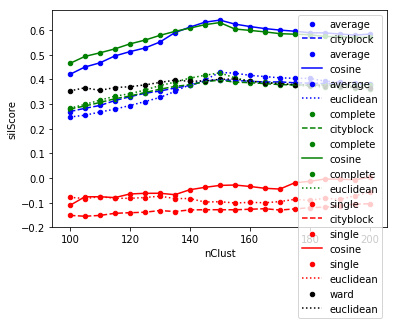

In [62]:
#Plot the Silhouette Scores to see the best models
fig, ax = plt.subplots()

colors = {'single':'red', 'average':'blue', 'complete':'green', 'ward':'black'}
lStyles = {'euclidean':':', 'cosine':"-", 'cityblock':'--'}
grouped = graphFrame.groupby(['cLink', 'cMetric'])
for key1, group in grouped:
    group.plot(ax = ax, kind='scatter', x='nClust', y='silScore', label=key1[0], color=colors[key1[0]])
    group.plot(ax = ax, kind = "line", x = "nClust", y = "silScore", label = key1[1], c = colors[key1[0]], ls = lStyles[key1[1]])

plt.show()

#plt.scatter("nClust", "silScore", data = graphFrame, c = "cLink")
#plt.show()

In [63]:
m = max(silScores)*0.95
print(m)
maxDF = graphFrame[graphFrame["silScore"] > m].sort_values(["silScore"], ascending = False)
maxDF = maxDF.iloc[:4]
maxDF

0.6087073385715485


cLink cMetric  nClust  silScore
97    average  cosine     150  0.640745
88    average  cosine     145  0.632279
98   complete  cosine     150  0.630711
106   average  cosine     155  0.624570

In [66]:
# Create the model corresponding to the top score: 

num_clusters = maxDF.nClust.iloc[0]
metric = maxDF.cMetric.iloc[0]
link = maxDF.cLink.iloc[0]
X = matrix_tfidf_lda.copy()

# Plot clustering results
clusterModel = AgglomerativeClustering(n_clusters=num_clusters, linkage=link, affinity=metric)

clusterModel = clusterModel.fit(X)


In [68]:
labels = clusterModel.labels_
print(len(labels))
print(labels[:10])

1979
[ 65  31 125  15  15  24 115  63 129 119]


In [87]:
clusterDF = newdf1.assign(Clusters = labels)
print(clusterDF.head())

fName = f'Data/Clusters/LDA_{num_topics}Topics_{num_clusters}{metric}_{link}.csv'
clusterDF.to_csv(fName)

   oldIndex Challenge SubChallenge  \
0         0    Health    Equipment   
1         1    Health    Equipment   
2         2    Health    Equipment   
3         3    Health    Equipment   
4         4    Health    Equipment   

                                             ProjURL                    title  \
0                  https://devpost.com/software/evam                    EVAM    
1            https://devpost.com/software/nanomaskcz               NanomaskCZ   
2  https://devpost.com/software/ecological-medica...  Ecological medical coat   
3  https://devpost.com/software/ecological-medica...  Ecological medical coat   
4  https://devpost.com/software/innovative-respir...           Respire Action   

                                                text  \
0  Inspiration\nThere is a huge shortage in the s...   
1  Inspiration\nThe story of Technical University...   
2  Inspiration\nWhat it does\nEconomic medical co...   
3  Inspiration\nThe simplicity and the economical...   
4  I

In [70]:
clusterDF.Clusters.value_counts()

2      92
24     89
19     78
7      51
3      37
11     37
32     37
0      35
51     35
44     33
12     30
26     28
104    26
16     26
1      25
15     25
58     23
101    23
27     22
140    21
31     21
14     19
13     19
56     19
82     18
102    18
63     18
130    18
75     17
6      17
       ..
110     6
107     6
41      6
98      5
81      5
134     5
142     5
94      5
105     5
118     5
50      5
120     5
79      4
147     4
37      4
133     4
135     4
122     4
69      4
106     4
91      3
103     3
148     3
115     3
72      3
95      2
111     2
146     2
127     2
138     2
Name: Clusters, Length: 150, dtype: int64

In [71]:
from scipy.cluster.hierarchy import dendrogram


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)




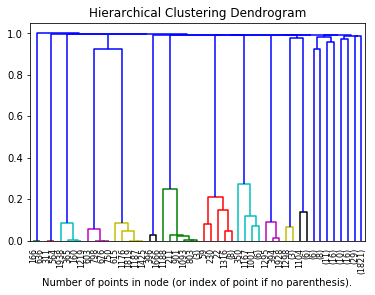

In [88]:

# setting distance_threshold=0 ensures we compute the full tree.
clusterModel = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage=link, affinity=metric)

clusterModel = clusterModel.fit(X)
plt.title('Hierarchical Clustering Dendrogram')

# plot the top ten levels of the dendrogram
plot_dendrogram(clusterModel, truncate_mode='level', p=10)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [90]:
from sklearn.cluster import KMeans
num_clusters = 100

km = KMeans(n_clusters=num_clusters)

%time km.fit(matrix_tfidf_lda)

CPU times: user 1min 26s, sys: 26.4 s, total: 1min 52s
Wall time: 14.3 s


KMeans(n_clusters=100)

In [99]:
clusters = km.labels_.tolist()
print(len(clusters))
for c in clusters[:10]:
    print(c)

1979
75
61
86
15
10
19
15
76
62
65


In [100]:
sil_score = metrics.silhouette_score(matrix_tfidf_lda, clusters, metric="euclidean")
sil_score

0.32643077

In [101]:
def compute_kMeans_silhouette(X, num_clust):
    km = KMeans(n_clusters = num_clusters)
    print(num_clust)
    km.fit(X)
    
    clusters = km.labels_.tolist()
    sil_score = metrics.silhouette_score(X, clusters, metric = "euclidean")
    
    return sil_score

In [102]:
temp = [10*x for x in range(10, 21)]

kMeansDF = pd.DataFrame({"nClust":temp})
kMeansDF

nClust
0      100
1      110
2      120
3      130
4      140
5      150
6      160
7      170
8      180
9      190
10     200

In [103]:
silScores = [compute_kMeans_silhouette(X = matrix_tfidf_lda, num_clust = n) for n in kMeansDF.nClust]
silScores

100
110
120
130
140
150
160
170
180
190
200


[0.33381447,
 0.3393311,
 0.3347992,
 0.3349956,
 0.32909703,
 0.32558563,
 0.3315818,
 0.33236206,
 0.3233692,
 0.3255502,
 0.33182567]

In [104]:
kMeansDF = kMeansDF.assign(silScore = silScores)
kMeansDF

nClust  silScore
0      100  0.333814
1      110  0.339331
2      120  0.334799
3      130  0.334996
4      140  0.329097
5      150  0.325586
6      160  0.331582
7      170  0.332362
8      180  0.323369
9      190  0.325550
10     200  0.331826

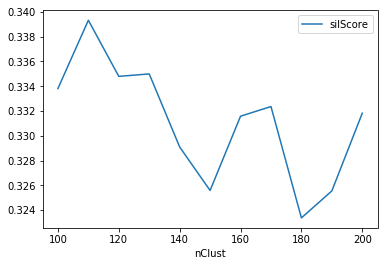

In [106]:
kMeansDF.plot(x = "nClust", y = "silScore", kind = "line")
plt.show()

In [117]:
from sklearn.cluster import OPTICS, cluster_optics_dbscan

clust = OPTICS(min_samples=5, xi=.05, min_cluster_size=.05)

# Run the fit
clust.fit(matrix_tfidf_lda)



OPTICS(min_cluster_size=0.05)

In [183]:
labels = [cluster_optics_dbscan(reachability=clust.reachability_,
                                   core_distances=clust.core_distances_,
                                   ordering=clust.ordering_, eps=round(e, 2)) for e in np.arange(0.1, 2.03, 0.05)]

print(len(labels))
numLabels = [len(set(l)) for l in labels]


39


In [184]:
colNames = ["eps_" + str(int(100*e)) for e in np.arange(0.1, 2.03, 0.05)]


In [ ]:
numLabelsDF = pd.DataFrame({"eps":colNames, "numLabels":numLabels}).sort_values("numLabels", ascending = False)

In [191]:

numLabelsDF = pd.DataFrame({"eps":colNames, "numLabels":numLabels})
print(numLabelsDF)

temp = pd.DataFrame(labels).transpose()
temp.columns = colNames
print(temp.shape)
print(temp.head())

        eps  numLabels
0    eps_10         20
1    eps_15         42
2    eps_20         60
3    eps_25         80
4    eps_30         96
5    eps_35         99
6    eps_40        103
7    eps_45         83
8    eps_50         48
9    eps_55         24
10   eps_60         13
11   eps_65          7
12   eps_70          4
13   eps_75          2
14   eps_80          2
15   eps_85          2
16   eps_90          2
17   eps_95          2
18  eps_100          2
19  eps_105          2
20  eps_110          1
21  eps_115          1
22  eps_120          1
23  eps_125          1
24  eps_130          1
25  eps_135          1
26  eps_140          1
27  eps_145          1
28  eps_150          1
29  eps_155          1
30  eps_160          1
31  eps_165          1
32  eps_170          1
33  eps_175          1
34  eps_180          1
35  eps_185          1
36  eps_190          1
37  eps_195          1
38  eps_200          1
(1979, 39)
   eps_10  eps_15  eps_20  eps_25  eps_30  eps_35  eps_40  eps_45  ep

In [242]:
temp1 = temp > 0

numLabelsDF = numLabelsDF.assign(nonZero = list(temp1.sum(axis = 0)))
numLabelsDF

eps  numLabels  nonZero
0    eps_10         20       91
1    eps_15         42      241
2    eps_20         60      380
3    eps_25         80      595
4    eps_30         96      830
5    eps_35         99     1123
6    eps_40        103     1428
7    eps_45         83     1692
8    eps_50         48     1847
9    eps_55         24      137
10   eps_60         13       71
11   eps_65          7       27
12   eps_70          4       10
13   eps_75          2        0
14   eps_80          2        0
15   eps_85          2        0
16   eps_90          2        0
17   eps_95          2        0
18  eps_100          2        0
19  eps_105          2        0
20  eps_110          1        0
21  eps_115          1        0
22  eps_120          1        0
23  eps_125          1        0
24  eps_130          1        0
25  eps_135          1        0
26  eps_140          1        0
27  eps_145          1        0
28  eps_150          1        0
29  eps_155          1        0
30  eps_160          1        0
31  eps_165          1        0
32  eps_170          1        0
33  eps_175          1        0
34  eps_180          1        0
35  eps_185          1        0
36  eps_190          1        0
37  eps_195          1        0
38  eps_200          1        0

In [243]:
useCols = numLabelsDF[numLabelsDF.nonZero > 0].eps
useCols

0     eps_10
1     eps_15
2     eps_20
3     eps_25
4     eps_30
5     eps_35
6     eps_40
7     eps_45
8     eps_50
9     eps_55
10    eps_60
11    eps_65
12    eps_70
Name: eps, dtype: object

In [260]:
sil_score = [metrics.silhouette_score(matrix_tfidf_lda, temp[c], metric = "minkowski") for c in useCols]
sil_score

[0.011660818964269947,
 -0.02755189061091832,
 0.008374264283202744,
 0.07789526553227892,
 0.12251112858160573,
 0.16463156453166713,
 0.19876475060817395,
 0.1849690444169945,
 0.11390364803131076,
 0.07970293179320871,
 0.0567525882938829,
 0.04984477842815236,
 0.04203830964619994]

In [262]:
s = sil_score.copy()
r = len(numLabelsDF) - len(sil_score)
s.extend([0]*r)
print(s)
print(len(s))
print(len(numLabelsDF))

[0.011660818964269947, -0.02755189061091832, 0.008374264283202744, 0.07789526553227892, 0.12251112858160573, 0.16463156453166713, 0.19876475060817395, 0.1849690444169945, 0.11390364803131076, 0.07970293179320871, 0.0567525882938829, 0.04984477842815236, 0.04203830964619994, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
39
39


In [263]:
numLabelsDF = numLabelsDF.assign(silScore = s)
numLabelsDF

eps  numLabels  nonZero  silScore
0    eps_10         20       91  0.011661
1    eps_15         42      241 -0.027552
2    eps_20         60      380  0.008374
3    eps_25         80      595  0.077895
4    eps_30         96      830  0.122511
5    eps_35         99     1123  0.164632
6    eps_40        103     1428  0.198765
7    eps_45         83     1692  0.184969
8    eps_50         48     1847  0.113904
9    eps_55         24      137  0.079703
10   eps_60         13       71  0.056753
11   eps_65          7       27  0.049845
12   eps_70          4       10  0.042038
13   eps_75          2        0  0.000000
14   eps_80          2        0  0.000000
15   eps_85          2        0  0.000000
16   eps_90          2        0  0.000000
17   eps_95          2        0  0.000000
18  eps_100          2        0  0.000000
19  eps_105          2        0  0.000000
20  eps_110          1        0  0.000000
21  eps_115          1        0  0.000000
22  eps_120          1        0  0.000000
23  eps_125          1        0  0.000000
24  eps_130          1        0  0.000000
25  eps_135          1        0  0.000000
26  eps_140          1        0  0.000000
27  eps_145          1        0  0.000000
28  eps_150          1        0  0.000000
29  eps_155          1        0  0.000000
30  eps_160          1        0  0.000000
31  eps_165          1        0  0.000000
32  eps_170          1        0  0.000000
33  eps_175          1        0  0.000000
34  eps_180          1        0  0.000000
35  eps_185          1        0  0.000000
36  eps_190          1        0  0.000000
37  eps_195          1        0  0.000000
38  eps_200          1        0  0.000000

Some interesting websites:
https://www.tutorialspoint.com/gensim/gensim_quick_guide.htm